## Part 0: Statistics

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import sklearn.preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import sem
from sklearn import preprocessing, linear_model, svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import norm, pareto, kstest
from statsmodels.graphics.gofplots import qqplot
import pandas.tseries
import warnings
warnings.filterwarnings("ignore")

/Users/shuo.jiang/anaconda/envs/tf/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# count the crime type information
dataset = pd.read_csv('data/all_data.csv')
print("Felony count:", dataset['LEVEL_FELONY'].sum())
print("Misdemeanor count:", dataset['LEVEL_MISDEMEANOR'].sum())
print("Violation count:", dataset['LEVEL_VIOLATION'].sum())

Felony count: 104370
Misdemeanor count: 190937
Violation count: 50131


In [3]:
# count the attempted crime and completed crime
raw_crime_data = pd.read_csv('new_data/NYPD_Complaint_Data_Current_YTD.csv')
raw_crime_data[['CMPLNT_FR_DT', 'CMPLNT_FR_TM','Latitude', 'Longitude', 'LAW_CAT_CD', 'CRM_ATPT_CPTD_CD']]\
                        .dropna()\
                        .groupby(['LAW_CAT_CD', 'CRM_ATPT_CPTD_CD']).size()

LAW_CAT_CD   CRM_ATPT_CPTD_CD
FELONY       ATTEMPTED             3786
             COMPLETED           100584
MISDEMEANOR  ATTEMPTED             1786
             COMPLETED           189151
VIOLATION    ATTEMPTED              127
             COMPLETED            50004
dtype: int64

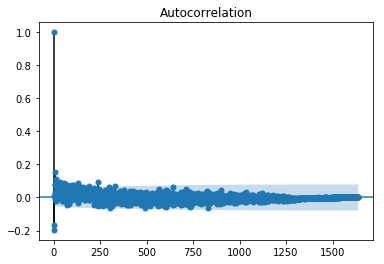

array([ 1.        , -0.19639618, -0.1655799 ,  0.00586295,  0.15394437,
        0.07567221,  0.03378799, -0.00649659,  0.08024847,  0.0194696 ,
        0.08047281,  0.00465602,  0.07181059, -0.01980267,  0.11083427,
        0.03914215,  0.00761313,  0.03608497,  0.04614281,  0.04752709,
        0.06551047,  0.01707124,  0.00541903,  0.05998683,  0.04154045,
        0.00815091,  0.0677394 ,  0.04941866,  0.02903561,  0.00900866,
        0.05555508,  0.07940152,  0.01457351, -0.00141309,  0.04241213,
        0.09087688,  0.00572589, -0.00681413,  0.0412672 ,  0.04687626,
        0.02688071])

In [4]:
# time series analysis of the crime time:'CMPLNT_FR_DT' is the column for the crime time
# acf
timeSeries = raw_crime_data.groupby(['CMPLNT_FR_DT']).size()
plot_acf(timeSeries)
plt.show()
acf(timeSeries)

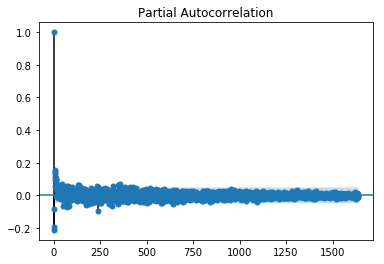

array([ 1.        , -0.19651608, -0.21261152, -0.08215651,  0.110982  ,
        0.1422263 ,  0.15506834,  0.09624408,  0.1289541 ,  0.0566604 ,
        0.107049  ,  0.04133734,  0.0882381 , -0.00691015,  0.09594221,
        0.06246254,  0.02901366,  0.04496594,  0.0200547 ,  0.03536351,
        0.05840555,  0.04247946, -0.00644979,  0.0338749 ,  0.00321921,
       -0.01387233,  0.03718213,  0.04661086,  0.0373511 ,  0.00584269,
        0.03430279,  0.06369292,  0.02742326, -0.00197517, -0.00194155,
        0.04720052,  0.00192811, -0.02234943, -0.01552239, -0.0104547 ,
       -0.01866257])

In [5]:
# pacf
plot_pacf(timeSeries)
plt.show()
pacf(timeSeries)

## Part 1
- Use Decision Tree, SVM and LR to predict the crime type of a location based upon location-related features

In [6]:
# read in data
dataset = pd.read_csv('data/all_data.csv')

In [7]:
# convert encoding
le = sklearn.preprocessing.LabelEncoder()
dataset['res_max_type'] = le.fit_transform(dataset['res_max_type'])

In [8]:
# split data into train and test data
def splitToTrainTest(dataframe, trainPercent):
    recordNum = dataframe.shape[0]
    shuffledIndex = np.random.permutation(np.arange(recordNum))
    trainSetNum = int(recordNum * trainPercent)
    trainDf, testDf = dataframe.iloc[shuffledIndex[:trainSetNum]], dataframe.iloc[shuffledIndex[trainSetNum:]]
    return trainDf, testDf
train_df, test_df = splitToTrainTest(dataset, 0.7)

In [9]:
# define target label and irrelevant labels
# target variable is LEVEL_MISDEMEANOR here
y_labels = ['LEVEL_MISDEMEANOR']
irrelevant_labels = ['lat', 'lon', 'date', 'time', 'zipcode', 'LEVEL_FELONY', 'LEVEL_MISDEMEANOR', 'LEVEL_VIOLATION'] + y_labels

In [10]:
# use decision tree to train data
clf = DecisionTreeClassifier(criterion='entropy')
X_train, X_test = train_df.drop(irrelevant_labels, axis='columns'), test_df.drop(irrelevant_labels, axis='columns') 
y_train, y_test = train_df[y_labels], test_df[y_labels]
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
# predict result and get accuracy
train_predict = clf.predict(X_train)
test_predict = clf.predict(X_test)
train_accuracy = metrics.accuracy_score(train_predict, y_train)
test_accuracy = metrics.accuracy_score(test_predict, y_test)

print('Train accuracy = {}\nTest accuracy = {}'.format(train_accuracy, test_accuracy))

Train accuracy = 0.5595766854420486
Test accuracy = 0.5541531573259225


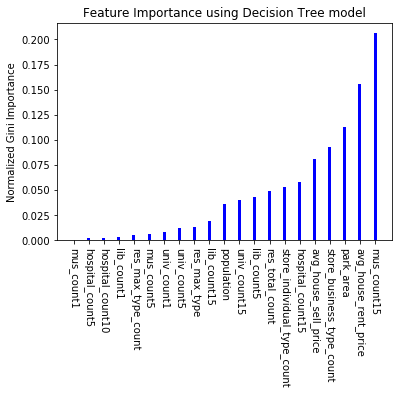

In [12]:
# extract the importance of each column and sort them according to importance value
new_df = pd.DataFrame({'importance':clf.feature_importances_, 'feature':X_train.columns.values})
new_df.sort_values('importance', axis = 0, inplace = True)

# draw the importance graph
fig, ax = plt.subplots()
ax.bar(np.arange(len(new_df['importance'].values)), new_df['importance'].values, width = 0.2, color='b')
ax.set_xticks(np.arange(len(new_df['importance'].values)))
ax.set_xticklabels(new_df['feature'].values, rotation=-90)
plt.title('Feature Importance using Decision Tree model')
ax.set_ylabel('Normalized Gini Importance')

In [13]:
# get the correlation matrix between features and target
train_df[[col_name for col_name in train_df.columns if col_name not in irrelevant_labels] + y_labels].corr()

,res_max_type,res_max_type_count,res_total_count,avg_house_sell_price,avg_house_rent_price,lib_count1,lib_count5,lib_count15,mus_count1,mus_count5,...,store_individual_type_count,univ_count1,univ_count5,univ_count15,population,hospital_count5,hospital_count10,hospital_count15,park_area,LEVEL_MISDEMEANOR
res_max_type,1.000000,0.510657,0.526366,0.295066,0.397046,-0.010978,-0.134089,-0.229073,0.220582,0.258497,...,0.101204,0.262966,0.288255,0.242640,0.112232,0.024642,-0.012178,-0.017096,-0.035320,0.014306
res_max_type_count,0.510657,1.000000,0.943027,0.303426,0.578984,-0.026971,-0.223154,-0.374920,0.395100,0.403159,...,-0.029801,0.317135,0.337161,0.303183,0.029275,-0.062092,-0.111363,-0.137713,-0.058798,0.009137
res_total_count,0.526366,0.943027,1.000000,0.366009,0.573121,-0.018419,-0.160252,-0.303960,0.416320,0.434930,...,0.026879,0.323561,0.348509,0.319827,0.125808,0.001376,-0.059458,-0.085228,-0.013072,0.013322
avg_house_sell_price,0.295066,0.303426,0.366009,1.000000,0.281698,-0.127313,-0.184180,-0.260499,0.400890,0.488069,...,-0.225566,0.206385,0.330946,0.319161,-0.223232,-0.032685,-0.037141,-0.041023,-0.172456,0.012464
avg_house_rent_price,0.397046,0.578984,0.573121,0.281698,1.000000,-0.198343,-0.334877,-0.458153,0.497332,0.541810,...,-0.349813,0.466495,0.546295,0.609209,-0.233567,0.035965,0.026419,0.046097,-0.168962,0.014358
lib_count1,-0.010978,-0.026971,-0.018419,-0.127313,-0.198343,1.000000,0.592275,0.368008,0.026726,-0.083133,...,0.270201,-0.049082,-0.104982,-0.147704,0.359291,0.056111,0.016011,-0.016855,0.201115,-0.012394
lib_count5,-0.134089,-0.223154,-0.160252,-0.184180,-0.334877,0.592275,1.000000,0.783678,-0.230780,-0.236548,...,0.337849,-0.088203,-0.060435,-0.144992,0.508239,0.285079,0.282801,0.246637,0.215234,-0.007720
lib_count15,-0.229073,-0.374920,-0.303960,-0.260499,-0.458153,0.368008,0.783678,1.000000,-0.310364,-0.305755,...,0.368974,-0.160699,-0.127039,-0.113615,0.516530,0.236419,0.294042,0.297158,0.158240,0.002833
mus_count1,0.220582,0.395100,0.416320,0.400890,0.497332,0.026726,-0.230780,-0.310364,1.000000,0.831607,...,-0.231276,0.388325,0.424293,0.475132,-0.199179,-0.117054,-0.119907,-0.113904,-0.131988,0.010938
mus_count5,0.258497,0.403159,0.434930,0.488069,0.541810,-0.083133,-0.236548,-0.305755,0.831607,1.000000,...,-0.311687,0.426508,0.582884,0.632689,-0.266708,-0.120536,-0.105364,-0.088591,-0.183862,0.019021


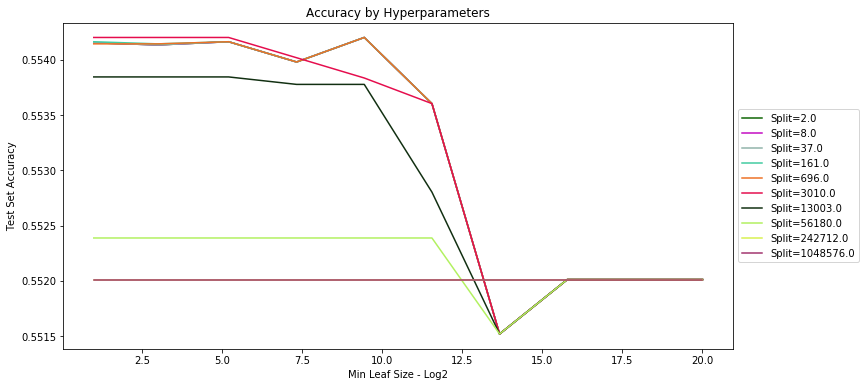

In [14]:
# hyper parameter selection in decision tree
min_samples_split_values = np.logspace(1, 20, num=10, base=2).astype(np.int)
min_samples_leaf_values = np.logspace(1, 20, num=10, base=2).astype(np.int)

def getAccuracy(train, test, min_samples_split_value, min_samples_leaf_value):
    treeModel = DecisionTreeClassifier(criterion='entropy', min_samples_split = min_samples_split_value, min_samples_leaf = min_samples_leaf_value)
    
    treeModel.fit(train['X'], train['y'])
    testPredict = treeModel.predict(test['X'])
    
    return metrics.accuracy_score(testPredict, test['y'])
    
 
res = {}
for min_samples_split_value in min_samples_split_values:
    res[min_samples_split_value] = []

for min_samples_split_value in min_samples_split_values:
    for min_samples_leaf_value in min_samples_leaf_values:
        res[min_samples_split_value].append(getAccuracy({'X':X_train, 'y':y_train}, {'X':X_test, 'y':y_test}, min_samples_split_value, min_samples_leaf_value))
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(111)

for min_samples_split_value in min_samples_split_values:
    plt.plot(np.log2(min_samples_leaf_values), res[min_samples_split_value], 
             color=(np.random.rand(),np.random.rand(),np.random.rand()), label='Split={}'.format(np.floor(min_samples_split_value)))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Min Leaf Size - Log2')
ax.set_ylabel('Test Set Accuracy')
plt.title('Accuracy by Hyperparameters')    
plt.show()

In [15]:
# plot roc curve
def plotROC(classifiers, classifier_names, X_train, y_train, X_test, y_test):
    plt.figure()
    for classifier, classifier_name in zip(classifiers, classifier_names):
        # Learn to predict
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        # Compute ROC curve and ROC area
        fpr, tpr, threshold = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
    
        # Plot
        lw = 2
        rand_color = np.random.rand(3,)
        plt.plot(fpr, tpr, c=rand_color,
                 lw=lw, label='%s ROC curve (area = %0.2f)' % (classifier_name, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

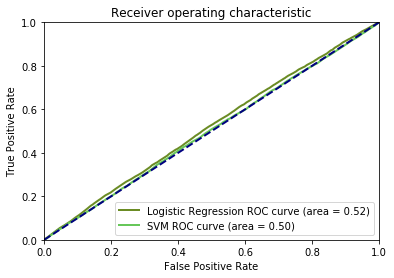

In [16]:
# build model: svm and logistic model

# logistic regression model
logistic_regression_model = linear_model.LogisticRegression(C = 1e30)

# svm model
svm_model = svm.SVC(kernel = 'linear')

# only use part of the dataset
sampled_train = train_df.sample(40000)
sampled_X_train = sampled_train.drop(irrelevant_labels, axis='columns')
sampled_y_train = sampled_train[y_labels]
data_train = {'X': preprocessing.scale(sampled_X_train), 'y': np.asarray(sampled_y_train.values.ravel(), dtype=np.int)}
data_test = {'X':preprocessing.scale(X_test), 'y':np.asarray(y_test.values.ravel(), dtype=np.int)}


# plot roc curve for logistic regression model and svm model
plotROC([logistic_regression_model, svm_model], ['Logistic Regression', 'SVM'],\
        data_train['X'], data_train['y'], data_test['X'], data_test['y'])

## Part 2
- Correlation Analysis
- SVM and LR used to predict whether the average crime rate in an area with same zipcode is larger than the average crime rate in the whole NYC

In [17]:
# read the whole dataset
rowData = pd.read_csv('data/all_data.csv')

In [18]:
# list the unique zipcode in the dataset
zipList = rowData['zipcode'].unique()

In [19]:
# create a new dataframe using unique zipcode as index
zip_Count = pd.DataFrame(index = zipList)
# set all max_type field to be 0
zip_Count['max_type'] = 0

In [20]:
# read in the house rent price data in nyc
ny_house_rent_data = pd.read_csv('new_data/ny_house_rent.csv')
ny_house_rent_data['avg_house_rent_price'] = ny_house_rent_data.drop('zipcode', axis='columns').mean(axis=1)
ny_house_rent_data = ny_house_rent_data[['zipcode','avg_house_rent_price']]
ny_house_rent_data.set_index('zipcode')


print(ny_house_rent_data.head(3))
ny_house_rent_data.loc[ny_house_rent_data['zipcode']==10025]

   zipcode  avg_house_rent_price
0    10025           3403.057143
1    10023           3693.414286
2    10002           3545.271429


,zipcode,avg_house_rent_price
0,10025,3403.057143


In [21]:
# read in the museum data
musData = pd.read_csv('data/NYC_Mus_zip_count.csv')
musData.head(2)

,Address ZIP,count1,count5,count15
0,10001,3,23,138
1,10002,2,11,97


In [22]:
# read in restaurant data
raw_restaurant_data = pd.read_csv('new_data/restaurant_data.csv')
restaurant_zip_sum_data = raw_restaurant_data.groupby(['zipcode']).sum().rename(index=int, columns={'count':'res_total_count'}).reset_index()
restaurant_zip_max_data = raw_restaurant_data.groupby(['zipcode']).max().rename(index=int, columns={'count':'res_max_type_count', 'type':'res_max_type'}).reset_index()
restaurant_data = restaurant_zip_max_data.join(restaurant_zip_sum_data.set_index('zipcode'), on='zipcode')

In [23]:
# read in population data
popuData = pd.read_csv('data/popu_zip.csv')
popuData.head(2)

,Unnamed: 0,population,zipcode,geo_id
0,376,1403,12917,8600000US12917
1,1043,250,14874,8600000US14874


In [24]:
# read in the house selling price in nyc
ny_house_sell_data = pd.read_csv('new_data/ny_house_sell.csv')
ny_house_sell_data['avg_house_sell_price'] = ny_house_sell_data.drop('zipcode', axis='columns').mean(axis=1)
ny_house_sell_data = ny_house_sell_data[['zipcode', 'avg_house_sell_price']]
ny_house_sell_data.head(2)

,zipcode,avg_house_sell_price
0,10025,907383.529412
1,11226,453584.705882


In [25]:
# read in the university data
univData = pd.read_csv('data/NYC_Univ_zip_count.csv')
univData.head(2)

,Address ZIP,count1,count5,count15
0,10001,1,11,86
1,10002,0,0,66


In [26]:
# integrate all the data into zip_count
for idx in zipList:
    tempData = rowData.loc[rowData['zipcode']==idx]
    LEVEL_FELONY_count = (tempData['LEVEL_FELONY'] == 1).sum()
    LEVEL_MISDEMEANOR_count = (tempData['LEVEL_MISDEMEANOR'] == 1).sum()
    LEVEL_VIOLATION_count = (tempData['LEVEL_VIOLATION'] == 1).sum()
    total_count = LEVEL_FELONY_count+LEVEL_MISDEMEANOR_count+LEVEL_VIOLATION_count
    max_count = max(LEVEL_FELONY_count, LEVEL_MISDEMEANOR_count, LEVEL_VIOLATION_count)
    #print(total_count)
    #print(max_count)
    if LEVEL_FELONY_count == max_count:
        #zip_Count[idx]['max_type'] = 1
        zip_Count.set_value(idx, 'max_type', 1)
    elif LEVEL_MISDEMEANOR_count == max_count:
        #zip_Count[idx]['max_type'] = 2
        zip_Count.set_value(idx, 'max_type', 2)
    else:
        #zip_Count[idx]['max_type'] = 3
        zip_Count.set_value(idx, 'max_type', 3)    
    #zip_Count[idx]['max_type_rate'] = max_count/total_count
    zip_Count.set_value(idx, 'VIOLATION_rate', LEVEL_VIOLATION_count/total_count)
    #features:
    if idx in ny_house_rent_data.zipcode.values:
        zip_Count.set_value(idx, 'avg_house_rent_price', ny_house_rent_data.loc[ny_house_rent_data['zipcode']==idx].avg_house_rent_price.values[0])
    else:
        zip_Count.set_value(idx, 'avg_house_rent_price', 0)
    #
    if idx in musData['Address ZIP'].values:
        zip_Count.set_value(idx, 'mus_count15', musData.loc[musData['Address ZIP']==idx].count15.values[0])
        zip_Count.set_value(idx, 'mus_count5',  musData.loc[musData['Address ZIP']==idx].count15.values[0])
    else:
        zip_Count.set_value(idx, 'mus_count15', 0)
        zip_Count.set_value(idx, 'mus_count5', 0)
    #
    if idx in restaurant_data.zipcode.values:
        zip_Count.set_value(idx, 'res_max_type', restaurant_data.loc[restaurant_data['zipcode']==idx].res_max_type.values[0])
    else:
        zip_Count.set_value(idx, 'res_max_type', 'NaN')
    #
    if idx in popuData.zipcode.values:
        zip_Count.set_value(idx, 'population', popuData.loc[popuData['zipcode']==idx].population.values[0])
    else:
        zip_Count.set_value(idx, 'population', 0)
    #
    if idx in ny_house_sell_data.zipcode.values:
        zip_Count.set_value(idx, 'avg_house_sell_price', ny_house_sell_data.loc[ny_house_sell_data['zipcode']==idx].avg_house_sell_price.values[0])
    else:
        zip_Count.set_value(idx, 'avg_house_sell_price', 0)
    #
    if idx in univData['Address ZIP'].values:
        zip_Count.set_value(idx, 'univ_count5', univData.loc[univData['Address ZIP']==idx].count5.values[0])
    else:
        zip_Count.set_value(idx, 'univ_count5', 0)

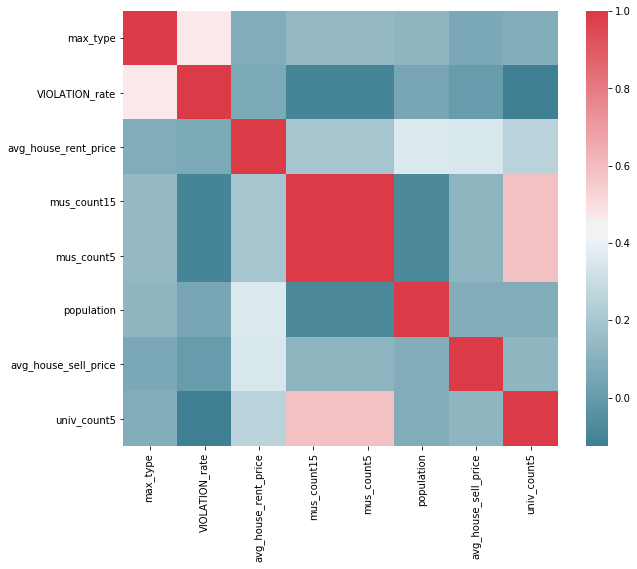

In [27]:
# draw correlation map
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = zip_Count.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import sklearn.preprocessing
from scipy import interp
import math

In [29]:
# calculate the average violation rate of nyc and 
# compare that with the average violation rate of each zipcode
mean_rate = zip_Count['VIOLATION_rate'].mean()
print(mean_rate)
zip_Count['Y'] = 0
for index, row in zip_Count.iterrows():
    if row['VIOLATION_rate']>=mean_rate:
        zip_Count.set_value(index, 'Y', 1)
zip_Count

0.14570990202610187


,max_type,VIOLATION_rate,avg_house_rent_price,mus_count15,mus_count5,res_max_type,population,avg_house_sell_price,univ_count5,Y
10026,2,0.139222,3032.985714,141.0,141.0,Vegetarian,34003.0,7.635953e+05,17.0,0
11231,2,0.089438,2687.500000,36.0,36.0,Vietnamese/Cambodian/Malaysia,33336.0,8.680918e+05,1.0,0
10302,2,0.192027,1971.742857,72.0,72.0,Spanish,19088.0,3.315129e+05,3.0,1
11212,2,0.170582,1875.028571,15.0,15.0,Spanish,84500.0,3.087435e+05,0.0,1
11372,2,0.139169,2010.971429,26.0,26.0,Thai,66636.0,0.000000e+00,2.0,0
10473,2,0.158479,1710.000000,0.0,0.0,Spanish,58519.0,3.135282e+05,0.0,1
11102,2,0.182540,2175.114286,61.0,61.0,Spanish,34133.0,0.000000e+00,0.0,1
11451,2,0.164694,0.000000,15.0,15.0,American,0.0,0.000000e+00,6.0,1
11419,2,0.177333,1922.028571,12.0,12.0,Vegetarian,47211.0,3.861224e+05,0.0,1
10018,2,0.094111,0.000000,94.0,94.0,Vietnamese/Cambodian/Malaysia,5229.0,0.000000e+00,7.0,0


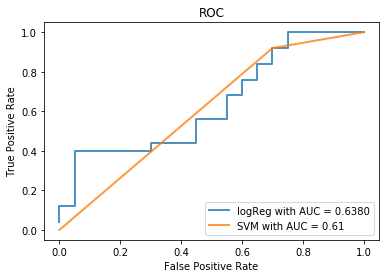

In [30]:
# convert encoding of restaurant type
le = sklearn.preprocessing.LabelEncoder()
zip_Count['res_max_type'] = le.fit_transform(zip_Count['res_max_type'])

totalRows = len(zip_Count.index)
train_df_idx = np.random.choice(zip_Count.index, math.ceil(totalRows*0.8), replace=False)
data_train = zip_Count.loc[train_df_idx]
data_test = zip_Count.loc[~zip_Count.index.isin(train_df_idx)]

y_labels = ['Y','VIOLATION_rate']
y_label = 'Y'
logReg_cla = LogisticRegression(C=1e5)
prob_l = logReg_cla.fit(data_train.drop(y_labels, axis=1), data_train[y_label]).predict_proba(data_test.drop(y_labels, axis=1))
pred = prob_l[:,1]

fact = np.array(data_test[y_label].tolist())
fpr, tpr, thresholds = roc_curve(data_test[y_label], pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.8,label='%s with AUC = %0.4f' % ('logReg', roc_auc))


###
#SVM
svm_cla_prob = svm.SVC(kernel='linear')
probas_ = svm_cla_prob.fit(data_train.drop(y_labels, axis=1), data_train[y_label]).predict(data_test.drop(y_labels, axis=1))
#pred = probas_[:, 1]
pred = probas_
fpr, tpr, thresholds = roc_curve(data_test[y_label], pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.8,label='%s with AUC = %0.2f' % ('SVM', roc_auc))


plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [37]:
# store the result dataset
zip_Count.to_csv('data/crime_baseonZIP.csv')

## My code

Train accuracy = 0.9936708860759493
Test accuracy = 0.6176470588235294


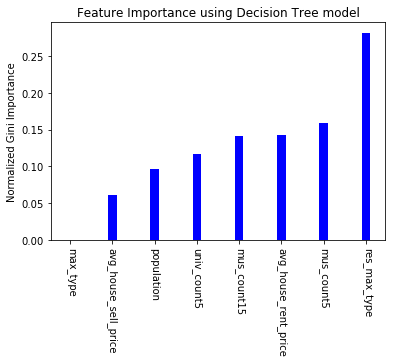

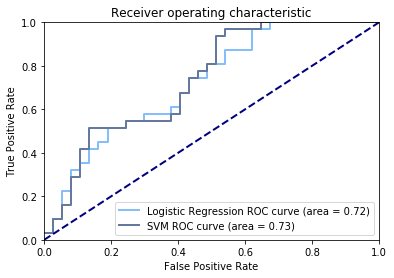

In [38]:
## read in data
dataset = pd.read_csv("data/crime_baseonZIP.csv").rename(columns={'Unnamed: 0':'zipcode'}, index=int)
train_df, test_df = splitToTrainTest(dataset, 0.7)

# define target label and irrelevant labels
# target variable is Y
y_labels = ['Y']
irrelevant_labels = ['zipcode', 'VIOLATION_rate']

# use decision tree to train data
clf = DecisionTreeClassifier(criterion='entropy')
X_train, X_test = train_df.drop(irrelevant_labels + y_labels, axis='columns'), test_df.drop(irrelevant_labels + y_labels, axis='columns') 
y_train, y_test = train_df[y_labels], test_df[y_labels]
clf.fit(X_train, y_train)

# predict result and get accuracy
train_predict = clf.predict(X_train)
test_predict = clf.predict(X_test)
train_accuracy = metrics.accuracy_score(train_predict, y_train)
test_accuracy = metrics.accuracy_score(test_predict, y_test)

print('Train accuracy = {}\nTest accuracy = {}'.format(train_accuracy, test_accuracy))

# extract the importance of each column and sort them according to importance value
new_df = pd.DataFrame({'importance':clf.feature_importances_, 'feature':X_train.columns.values})
new_df.sort_values('importance', axis = 0, inplace = True)

# draw the importance graph
fig, ax = plt.subplots()
ax.bar(np.arange(len(new_df['importance'].values)), new_df['importance'].values, width = 0.2, color='b')
ax.set_xticks(np.arange(len(new_df['importance'].values)))
ax.set_xticklabels(new_df['feature'].values, rotation=-90)
plt.title('Feature Importance using Decision Tree model')
ax.set_ylabel('Normalized Gini Importance')

# build model: svm and logistic model

# logistic regression model
logistic_regression_model = linear_model.LogisticRegression(C = 1e30)

# svm model
svm_model = svm.SVC(kernel = 'linear')

# only use part of the dataset
sampled_train = train_df
sampled_X_train = sampled_train.drop(irrelevant_labels + y_labels, axis='columns')
sampled_y_train = sampled_train[y_labels]
data_train = {'X': preprocessing.scale(sampled_X_train), 'y': np.asarray(sampled_y_train.values.ravel(), dtype=np.int)}
data_test = {'X':preprocessing.scale(X_test), 'y':np.asarray(y_test.values.ravel(), dtype=np.int)}

# plot roc curve for logistic regression model and svm model
plotROC([logistic_regression_model, svm_model], ['Logistic Regression', 'SVM'],\
        data_train['X'], data_train['y'], data_test['X'], data_test['y'])